<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Нейросеть-глубокого-обучения" data-toc-modified-id="Нейросеть-глубокого-обучения-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Нейросеть глубокого обучения</a></span></li><li><span><a href="#Модель-на-базе-библиотеки-prophet-от-Facebook" data-toc-modified-id="Модель-на-базе-библиотеки-prophet-от-Facebook-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель на базе библиотеки prophet от Facebook</a></span></li><li><span><a href="#Модель-SARIMAX" data-toc-modified-id="Модель-SARIMAX-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель SARIMAX</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

# Инструменты

pandas  
matplotlib  
numpy   
seaborn   
sklearn   
statsmodels  
tensorflow  
prophet  
SARIMAX  
optuna  


## Подготовка

In [ ]:
!pip install prophet
!pip install optuna

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.stattools import adfuller
import sys
import itertools
import os

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate, KFold, TimeSeriesSplit
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

import optuna
from optuna.trial import TrialState
from statistics import mean
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm

from matplotlib.ticker import (MultipleLocator, 
                               FormatStrFormatter, 
                               AutoMinorLocator)

In [2]:
plt.rcParams["figure.figsize"] = (18,9)
plt.rcParams["xtick.labelsize"] = 7
plt.rcParams["ytick.labelsize"] = 12

In [3]:
#Это путь для загурзки в среде Практикума
pth1 = '/datasets/taxi.csv'
pth2 = 'E:\\Data\\_Projects\\datasets\\taxi.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    df = pd.read_csv(pth2,index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

In [4]:
#Реиндексируем по дате и сгруппируем по вызовам в час
df.sort_index(inplace=True)
df = df.resample('1H').sum()
df.head(6)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6


## Анализ

In [5]:
#Убедимся в отсутствии пропусков
df.isna().sum()

num_orders    0
dtype: int64

Сначала посмотрим как выглядит наш датасет на графике

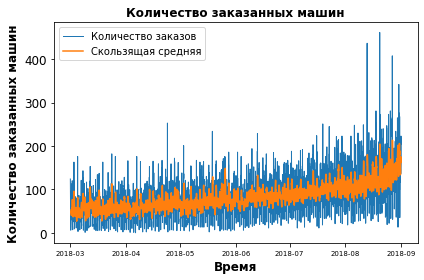

In [6]:
#plot time series
df['rolling_mean'] =df['num_orders'].rolling(10).mean()  
fig, ax = plt.subplots()

line_up, =ax.plot(df.index , df['num_orders'].values , linewidth= 1 , label='Количество заказов')
line_down, = ax.plot(df.index, df['rolling_mean'].values, '-', label='Скользящая средняя')
ax.set_xlabel('Время',fontsize='large', fontweight='bold')
ax.set_ylabel('Количество заказанных машин',fontsize='large', fontweight='bold')
ax.set_title('Количество заказанных машин',fontsize='large', fontweight='bold')

fig.tight_layout()
ax.legend(handles=[line_up, line_down])
plt.show()

Видно, что данные у нас с марта по сентябрь. Попробуем теперь бросить взгляд на каждый месяц отдельно. При этом стационарность ряда сомнительна исходя из формы графика скользящей средней.

In [7]:
itog = df.describe()
itog

,num_orders,rolling_mean
count,4416.000000,4407.00000
mean,84.422781,84.33735
std,45.023853,29.72319
min,0.000000,27.00000
25%,54.000000,62.60000
50%,78.000000,80.20000
75%,107.000000,100.70000
max,462.000000,213.40000


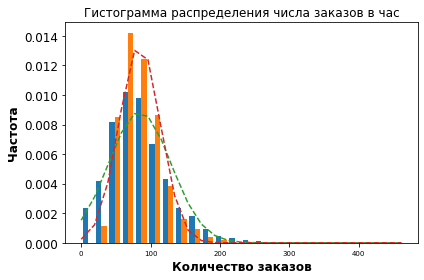

In [8]:
num_bins = 24
fig, ax = plt.subplots()
mu = df.mean()
sigma = df.std()  
n, bins, patches = ax.hist(df, num_bins, density=True)
y=[]
for b in bins:
    y.append(((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (b - mu))**2)))
ax.plot(bins, y, '--')
ax.set_xlabel('Количество заказов',fontsize='large', fontweight='bold')
ax.set_ylabel('Частота',fontsize='large', fontweight='bold')
ax.set_title('Гистограмма распределения числа заказов в час')

fig.tight_layout()
plt.show()

График выглядит достаточно естествнно. Распределение несколько напоминает нормальное, данные укалываются в логику процесса. Спрос на такси  не бывает нулевым, даже в плохие часы, а значения под 200 заказов в час встречаются очень-очень редко.

In [9]:
df['month'] = df.index.month
lines=df['month'].unique()

<Figure size 576x432 with 0 Axes>

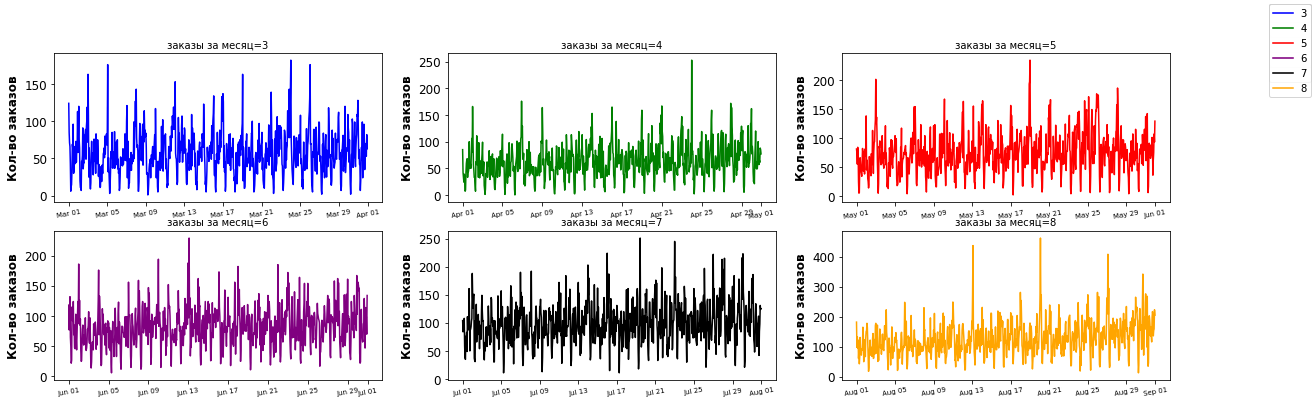

In [10]:
plt.figure(figsize=(8, 6))
colors=['blue','green','red','purple','black','orange','brown']
mnth=list(lines)
formatter = mdates.DateFormatter('%b %d')
# Две строки, два столбца. Текущая ячейка - 1
f, axs = plt.subplots(2, 3, figsize=(20, 6))
sp={0:[0,0],1:[0,1],2:[0,2],3:[1,0],4:[1,1],5:[1,2]}
for i in range(len(mnth)):
    p_slice=df[df['month']==lines[i]]
    y=np.array(p_slice['num_orders'])
    x=p_slice.index
    # Две строки, два столбца. Текущая ячейка - 1
    axs[sp[i][0], sp[i][1]].plot( x,y, color=colors[i], label=mnth[i])
    axs[sp[i][0], sp[i][1]].set_title('заказы за 'fr'месяц={lines[i]:.0f}',fontsize='medium', fontweight='normal')
    axs[sp[i][0], sp[i][1]].set_ylabel('Кол-во заказов',fontsize='large', fontweight='bold')
    axs[sp[i][0], sp[i][1]].tick_params(axis='x', rotation=10)
    axs[sp[i][0], sp[i][1]].xaxis.set_major_formatter(formatter)
    
    f.legend()

f.show()

Из увиденного можно сделать вывод о наличии повышательного тренда и значительных сезонных колебаниям, которые уже не так просто оценить "на глаз".

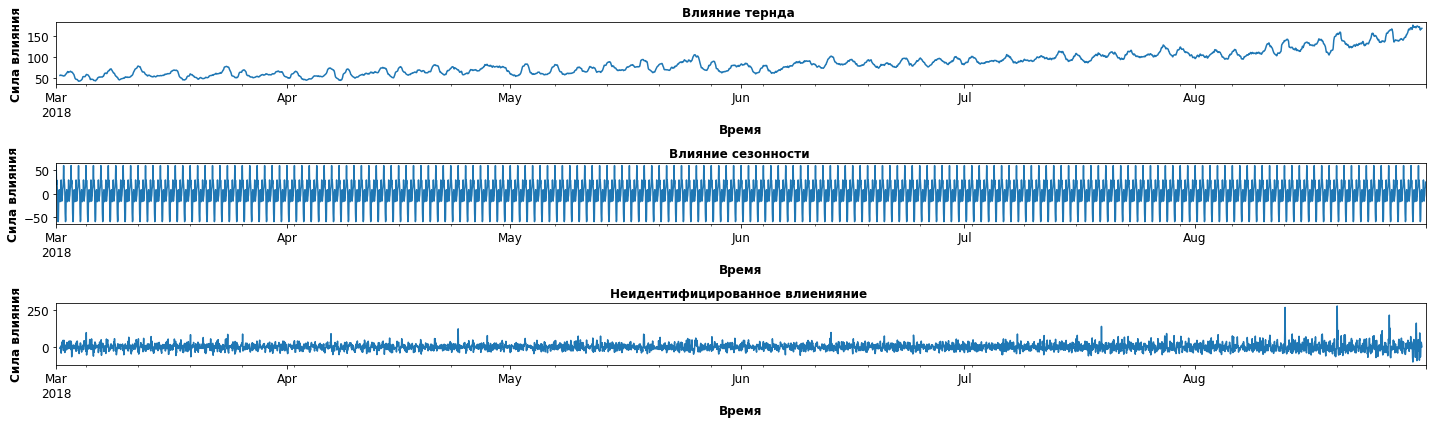

In [41]:
decomposed =seasonal_decompose(df['num_orders'])  
plt.rc('xtick', labelsize=12) 
f, axs = plt.subplots(3, 1, figsize=(20, 6),layout='tight')
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=axs[0])
axs[0].set_title('Влияние тернда ',fontsize='large', fontweight='bold')
axs[0].set_ylabel('Сила влияния',fontsize='large', fontweight='bold')
axs[0].set_xlabel('Время',fontsize='large', fontweight='bold')
decomposed.seasonal.plot(ax=axs[1]) 
axs[1].set_title('Влияние сезонности ',fontsize='large', fontweight='bold')
axs[1].set_ylabel('Сила влияния',fontsize='large', fontweight='bold')
axs[1].set_xlabel('Время',fontsize='large', fontweight='bold')
decomposed.resid.plot(ax=axs[2])
axs[2].set_title('Неидентифицированное влиенияние ',fontsize='large', fontweight='bold')
axs[2].set_ylabel('Сила влияния',fontsize='large', fontweight='bold')
axs[2].set_xlabel('Время',fontsize='large', fontweight='bold')
plt.show()

Разложение временного ряда на компоненты сделало наш тренд более понятным и чётким, а вот с сезонностью стало даже менее понятно. Остатки выглядят достаточно большими с возрастающей дисперсией, что точно скажется на точности нашего прогноза не лучшим образом.

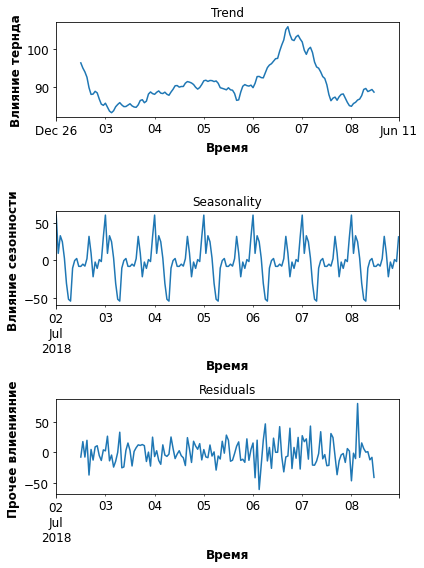

In [42]:
#Рассмотрим теперь график на более коротком промежутке в 1 неделю:
slice = df['2018-07-02':'2018-07-08']
decomposed_slice=seasonal_decompose(slice['num_orders']) 
plt.rc('xtick', labelsize=12) 
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed_slice.trend.plot(ax=plt.gca())
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.label.set_size(12)
plt.title('Trend')
plt.gca().set_ylabel('Влияние тернда',fontsize='large', fontweight='bold')
plt.gca().set_xlabel('Время',fontsize='large', fontweight='bold')
plt.subplot(312)
decomposed_slice.seasonal.plot(ax=plt.gca()) 
plt.gca().xaxis.label.set_size(12)
plt.title('Seasonality')
plt.gca().set_ylabel('Влияние сезонности ',fontsize='large', fontweight='bold')
plt.gca().set_xlabel('Время',fontsize='large', fontweight='bold')
plt.subplot(313)
decomposed_slice.resid.plot(ax=plt.gca())
plt.gca().xaxis.label.set_size(12)
plt.title('Residuals')
plt.gca().set_ylabel('Прочее влиенияние ',fontsize='large', fontweight='bold')
plt.gca().set_xlabel('Время',fontsize='large', fontweight='bold')
plt.tight_layout()

Из укрупнённого графика становится понятно, что пик приходится на вечер пятницы, что и понятно, а внутри дня происходит примерно такая картина - окло полуночи - пик, все хотят либо убраться из аэропорта либо попасть туда ещё сегодня, потом всё это постепернно затухает к середине ночи, когда уже нет сил ни ехать, ни лететь. К утру начинается оживаление, и ещё один локальный пик после обеда, который потом слегка сглаживается и опять наступает рывок к следующему полуночному пику.

In [43]:
#Убедимся в том, что наш временной ряд нестационарный. Для этого применим расширенный тест Дики – Фуллера
result = adfuller(df['num_orders'], autolag='AIC')

print('Критерий ADF: %f' % result[0])

print('P-значение: %f' % result[1])
print("Примем нулевую гипотезу о том, что временной ряд нестационерен (его среднее и cтандарное значение изменяются).")

print('Критические значения:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    if result[0] < result[4][key]:
        print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
    else:
        print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940
Примем нулевую гипотезу о том, что временной ряд нестационерен (его среднее и cтандарное значение изменяются).
Критические значения:
	1%: -3.432
Нулевая гипотеза не отвергнута – Временной ряд не стационарен
	5%: -2.862
Нулевая гипотеза отвергнута – Временной ряд стационарен
	10%: -2.567
Нулевая гипотеза отвергнута – Временной ряд стационарен


**Вывод**

Проверка  на P=`0.01` (самая точная) метододом Дикки-Фуллера показала что временной ряд не стационарен. Такое же впечатление создалось и при первом взгляде на график. Постараемся учесть это при проверке модели.

## Обучение

### Линейная регрессия

Сделаем классическую модель линейной регрессии, чтобы знать какой резльтат нам надо превозойти.

In [44]:
#Добавим признаков, чтобы модели было проще учиться

In [45]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [46]:
df_new=make_features(df, 168, 24)

In [47]:
#Для начала отщипнём от набора данных хвост, чтобы на нём тестировать модель
train, test = train_test_split(df_new, shuffle=False, test_size=0.1)
df_train = train.dropna()
x_train=df_train.drop('num_orders', axis=1)
y_train=df_train['num_orders']

In [53]:
#сохраним данные для теста линейой регрессии на поздих этапах
xl_train=x_train
yl_train=y_train
xl_test=test.dropna()
xl_test=xl_test.drop('num_orders', axis=1)
yl_test=test['num_orders']

In [49]:
#Посчитаем длинну наших выборок, это нам понадобится позднее
print("Test Shape=",test.shape)
print("Train Shape=",train.shape)
test_size=test.shape[0]
train_size=train.shape[0]

Test Shape= (442, 173)
Train Shape= (3974, 173)


In [50]:
tscv = TimeSeriesSplit(n_splits=3)

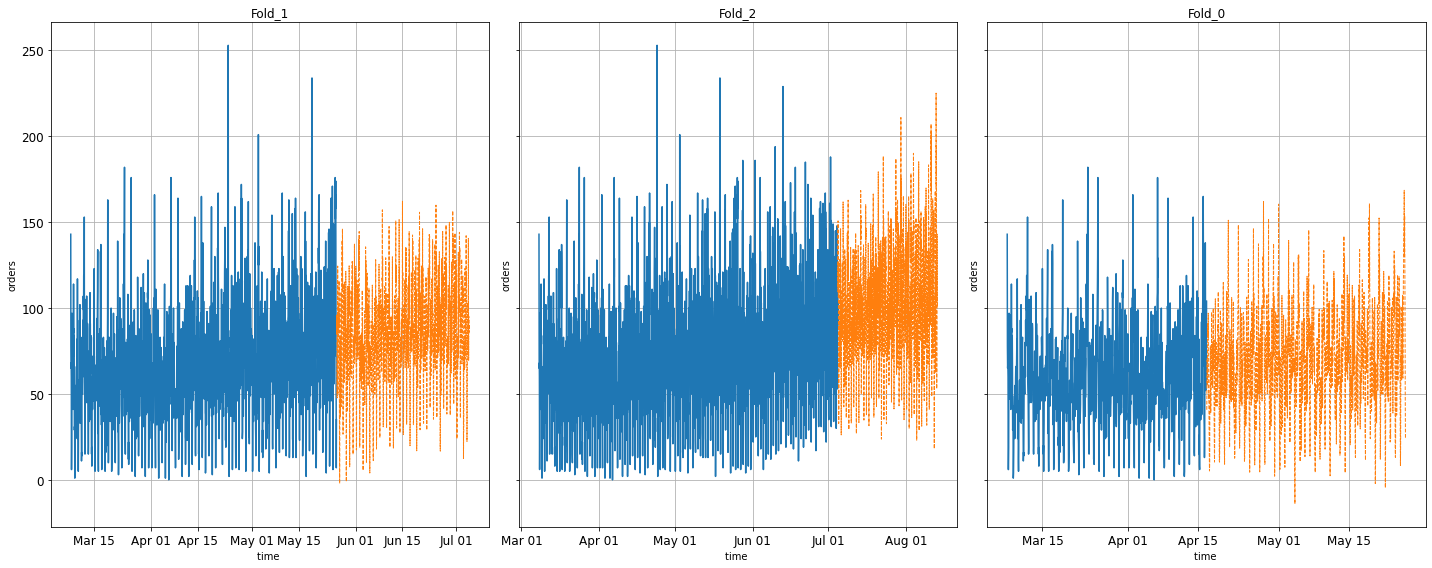

Результаты кросс-валидации линейной регрессии  [21.41883835966317, 21.21564053272368, 26.628235449570468]


In [51]:
rmsez=[]
t=train['num_orders'].copy()
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True,figsize=(20, 8))

for fold, (train_index, test_index) in enumerate(tscv.split(x_train)):
    model = LinearRegression()
    model.fit(x_train.iloc[train_index], y_train.iloc[train_index])
    pred=model.predict(x_train.iloc[test_index])
    loss = mean_squared_error(y_train.iloc[test_index], pred, squared=False)
    rmsez.append(loss)

    axs[fold-1].plot(y_train.iloc[train_index].index, y_train.iloc[train_index].values)
    axs[fold-1].set(xlabel='time ', ylabel='orders',title='Fold_{}'.format(fold))
    axs[fold-1].plot(y_train.iloc[test_index].index, pred,'--',linewidth=1)

    axs[fold-1].xaxis.set_major_formatter(formatter)
    axs[fold-1].grid()
    fold=fold+1
plt.show()
print("Результаты кросс-валидации линейной регрессии ",rmsez)

In [52]:
eva=pd.DataFrame(columns=['Model','RMSE Fold1','RMSE Fold2','RMSE Fold3','Усреднённое RMSE'])
l=['Линейная регрессия']+rmsez+[mean(rmsez)]
eva=eva.append(pd.Series(l, index=eva.columns), ignore_index=True)
eva

,Model,RMSE Fold1,RMSE Fold2,RMSE Fold3,Усреднённое RMSE
0,Линейная регрессия,21.418838,21.215641,26.628235,23.087571


**Вывод**

Кросс-валидация показала, что линейная регрессия выдаёт очень хорошую метрику, достаточно стабильна от этапа к этапу. Теперь у нас есть отличный оринетир, который мы постараемся превозйти с помощью других алгоритмов.

### Нейросеть глубокого обучения

**Попробуем спрогнозировать с помощью нейросети с глубоким обучением**

In [54]:
#Зафиксируем "семя" генератора случайных чисел для воспроизводимости данных
tf.random.set_seed(1234)

In [55]:
# Выделим надор данных для обучения нейросети
df_lstm = train[['num_orders']].copy()
df_lstm

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-13 09:00:00,137
2018-08-13 10:00:00,156
2018-08-13 11:00:00,144


In [56]:
# Нормализуем данные
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_lstm)
scaled_data

array([[0.28375286],
       [0.19450801],
       [0.1624714 ],
       ...,
       [0.32951945],
       [0.21052632],
       [0.27231121]])

In [57]:
# Напишем функцию которая будет группировать данные в удобные для обучения последовательности
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        label = data[i+sequence_length]
        X.append(seq)
        y.append(label)
    return np.array(X), np.array(y)

In [58]:
# Зададим длинну последовательности достаточно большую, чтобы отлавливать сезонность
sequence_length = 100  
X_train, y_train = create_sequences(scaled_data, sequence_length)

In [59]:
# Изменим размерность обучающих данных, чтобы совпадала со входным форматом первого слоя нейросети
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(3874, 100, 1)

In [60]:
# Зададим архитектуру нейросети

def create_model():
    net = Sequential()
    net.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    net.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    net.add(LSTM(units=50))
    net.add(Dense(units=1))
    net.compile(optimizer='adam', loss='mean_squared_error')
    return net


31/31 [==============================] - 1s 16ms/step


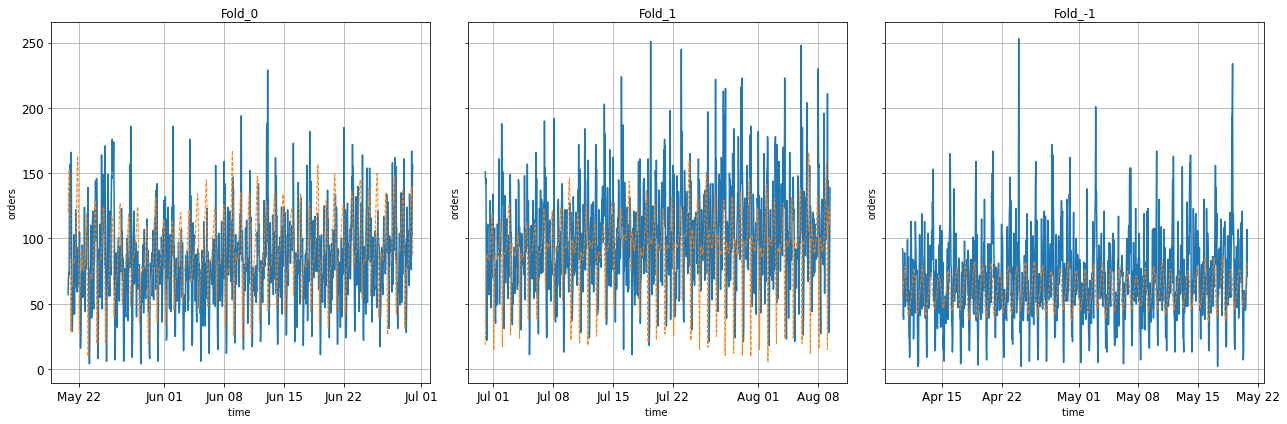

Результаты кросс-валидации нейросети  [61.07881162380123, 93.20658787943411, 97.53074258324378]


In [61]:
rmsez=[]
t=train['num_orders'].copy()
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True,figsize=(18, 6))
for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    net = create_model()
    net.fit(X_train[train_index], y_train[train_index], epochs=10,batch_size=24, verbose=0)
    loss = net.evaluate(X_train[test_index], y_train[test_index])
    axs[fold-1].plot(t[test_index].index, t[test_index].values)
    axs[fold-1].set(xlabel='time ', ylabel='orders',title='Fold_{}'.format(fold-1))
    preds=net.predict(X_train[test_index])
    preds=scaler.inverse_transform(preds)
    axs[fold-1].plot(t[test_index].index, preds,'--',linewidth=1)
    axs[fold-1].xaxis.set_major_formatter(formatter)

    axs[fold-1].grid()
    r=mean_squared_error(y_train[test_index], preds, squared=False)
    rmsez.append(r)

plt.show()
print("Результаты кросс-валидации нейросети ",rmsez)


In [62]:
l=pd.Series(rmsez)
l=pd.concat([pd.Series('Нейросеть'), l,pd.Series(mean(rmsez))])
l=l.set_axis(eva.columns)
eva=eva.append(l, ignore_index=True)
eva

,Model,RMSE Fold1,RMSE Fold2,RMSE Fold3,Усреднённое RMSE
0,Линейная регрессия,21.418838,21.215641,26.628235,23.087571
1,Нейросеть,61.078812,93.206588,97.530743,83.938714


Нейросеть показала просто весьма посредственные результаты на кросс-валидации, и что характерно они тоже ухудшаются. Отсюда надежды на хороший результат на тестовой выборке тоже почти нет.

### Модель на базе библиотеки prophet от Facebook

**Теперь попробуем спрогнозировать с помощью библиотеки prophet**

In [63]:
#Подготовим исходные данные для обучения "пророка", так как у него свои требования к формату входных данных
df_pr = train[['num_orders']].copy()
df_pr['date'] = df_pr.index
cols=['date','num_orders']
df_pr = df_pr[cols]
df_pr = df_pr.rename(columns={'date': 'ds', 'num_orders': 'y'})
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3974 entries, 2018-03-01 00:00:00 to 2018-08-13 13:00:00
Freq: H
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3974 non-null   datetime64[ns]
 1   y       3974 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 93.1 KB


In [64]:
#Инициализируем модель
m = Prophet(daily_seasonality=True, weekly_seasonality=True, seasonality_mode='multiplicative',changepoint_prior_scale=0.01)
m.fit(df_pr)

15:46:36 - cmdstanpy - INFO - Chain [1] start processing
15:46:36 - cmdstanpy - INFO - Chain [1] done processing


In [65]:
#Создадтим будущее размером с нашу тестовую выборку, и с периодичностью в 1 час
future = m.make_future_dataframe(periods=test_size,freq='H')
future.tail()

,ds
4411,2018-08-31 19:00:00
4412,2018-08-31 20:00:00
4413,2018-08-31 21:00:00
4414,2018-08-31 22:00:00
4415,2018-08-31 23:00:00


In [66]:
#Создадим прогноз:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4411,2018-08-31 19:00:00,121.823326,90.314306,153.068113
4412,2018-08-31 20:00:00,132.167538,98.851855,164.415598
4413,2018-08-31 21:00:00,155.170338,124.104051,186.984091
4414,2018-08-31 22:00:00,175.635160,142.207866,206.403435
4415,2018-08-31 23:00:00,186.027125,153.754777,220.049951


Text(56.375, 0.5, 'Кол-во закзов такси')

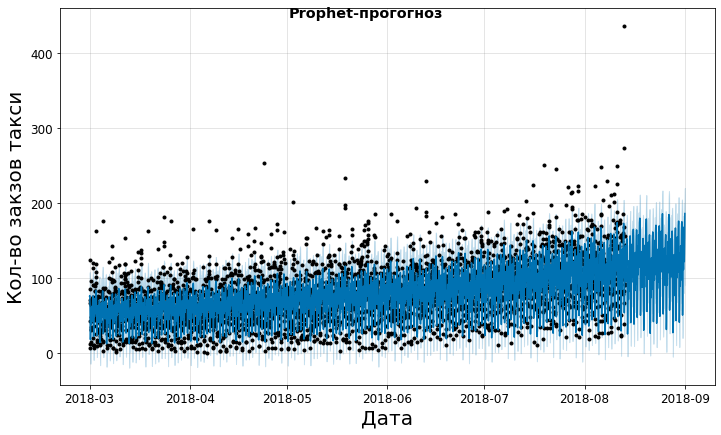

In [67]:
#Посмоитрим как это выглядит на графике
plt.rcParams["xtick.labelsize"] = 12
fig1 = m.plot(forecast)
fig1.suptitle('Prophet-прогогноз',fontsize='x-large', fontweight='bold')
plt.xlabel("Дата", fontsize=20)
plt.ylabel("Кол-во закзов такси",fontsize=20)

15:46:37 - cmdstanpy - INFO - Chain [1] start processing
15:46:37 - cmdstanpy - INFO - Chain [1] done processing
15:46:38 - cmdstanpy - INFO - Chain [1] start processing
15:46:38 - cmdstanpy - INFO - Chain [1] done processing
15:46:38 - cmdstanpy - INFO - Chain [1] start processing
15:46:38 - cmdstanpy - INFO - Chain [1] done processing


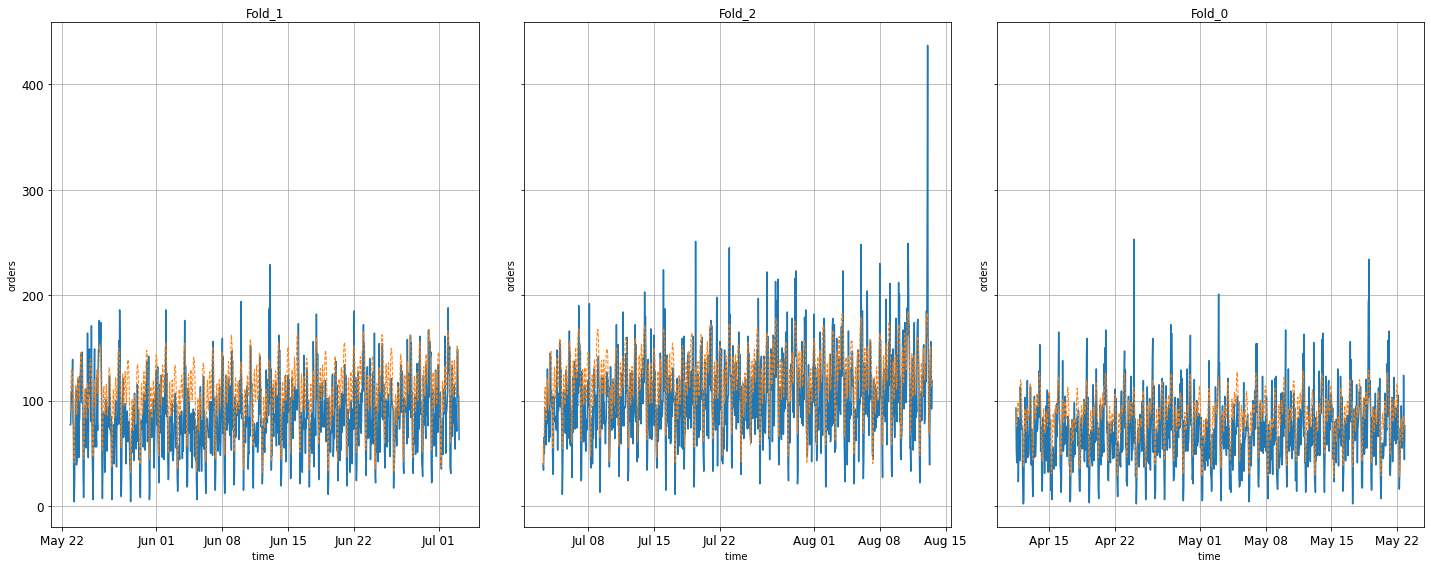

Результаты кросс-валидации Prophet  [27.81336156545981, 35.559376892670166, 35.33662034151145]


In [68]:
rmsez=[]
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True,figsize=(20, 8))

for fold, (train_index, test_index) in enumerate(tscv.split(df_pr)):
    m = Prophet(daily_seasonality=True, weekly_seasonality=True, seasonality_mode='multiplicative',changepoint_prior_scale=0.01)
    m.fit(df_pr.iloc[train_index])
    future = m.make_future_dataframe(periods=len(test_index),freq='H')
    forecast = m.predict(future)
    pred=forecast['yhat_upper'].tail(len(df_pr.iloc[test_index]))

    loss = mean_squared_error(df_pr.iloc[test_index].reset_index()['y'], pred.astype(int), squared=False)
    rmsez.append(loss)

    axs[fold-1].plot(df_pr.iloc[test_index].index, df_pr.iloc[test_index]['y'])
    axs[fold-1].set(xlabel='time ', ylabel='orders',title='Fold_{}'.format(fold))
    axs[fold-1].plot(df_pr.iloc[test_index].index, pred,'--',linewidth=1)
    
    axs[fold-1].xaxis.set_major_formatter(formatter)
    axs[fold-1].grid()
plt.show()
print("Результаты кросс-валидации Prophet ",rmsez)

In [69]:
l=pd.Series(rmsez)
l=pd.concat([pd.Series('Prophet'), l,pd.Series(mean(rmsez))])
l=l.set_axis(eva.columns)
eva=eva.append(l, ignore_index=True)
eva

,Model,RMSE Fold1,RMSE Fold2,RMSE Fold3,Усреднённое RMSE
0,Линейная регрессия,21.418838,21.215641,26.628235,23.087571
1,Нейросеть,61.078812,93.206588,97.530743,83.938714
2,Prophet,27.813362,35.559377,35.336620,32.903120


**Вывод**

Эта библиотека показала гораздо более точный результат на тестовой метрике на кросс-валидации, по сравнению с нейросетью. Но это вселяет надежду, что это не было чистым результатом переобучения, и что на тестовой выборке она себя ещё покажет.


### Модель SARIMAX

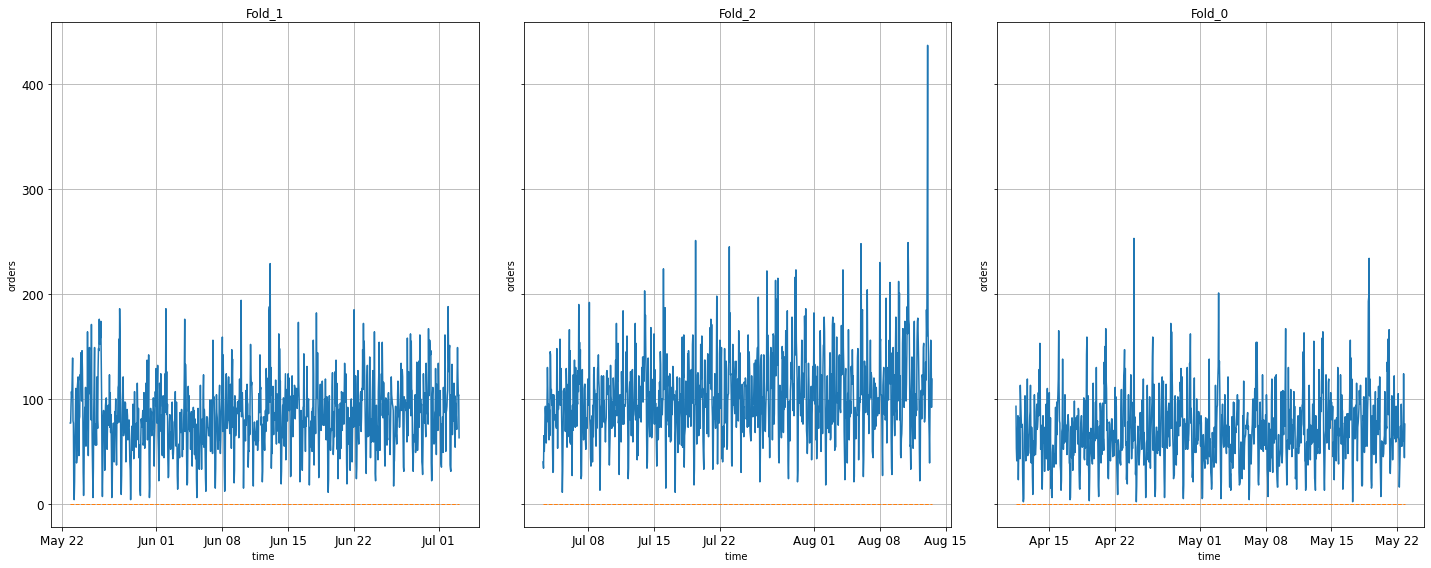

Результаты кросс-валидации SARIMAXa  [76.89097184231704, 89.94305572366537, 111.28275681230323]


In [70]:
rmsez=[]
t=train['num_orders'].copy()

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True,figsize=(20, 8))

for fold, (train_index, test_index) in enumerate(tscv.split(t)):
    sarimax=sm.tsa.statespace.SARIMAX(t[train_index],order=(0, 0, 0),seasonal_order=(0,0,0,12))
    resultz=sarimax.fit()
    pred=resultz.predict(start=len(train_index),end=len(train_index)+len(test_index)-1,dynamic=True)
    loss = mean_squared_error(t[test_index], pred, squared=False)
    rmsez.append(loss)

    axs[fold-1].plot(t[test_index].index, t[test_index].values)
    axs[fold-1].set(xlabel='time ', ylabel='orders',title='Fold_{}'.format(fold))
    axs[fold-1].plot(t[test_index].index, pred,'--',linewidth=1)
    axs[fold-1].xaxis.set_major_formatter(formatter)
    axs[fold-1].grid()
plt.show()
print("Результаты кросс-валидации SARIMAXa ",rmsez)

In [71]:
l=pd.Series(rmsez)
l=pd.concat([pd.Series('SARIMAX без оптимизации'), l,pd.Series(mean(rmsez))])
l=l.set_axis(eva.columns)
eva=eva.append(l, ignore_index=True)
eva

,Model,RMSE Fold1,RMSE Fold2,RMSE Fold3,Усреднённое RMSE
0,Линейная регрессия,21.418838,21.215641,26.628235,23.087571
1,Нейросеть,61.078812,93.206588,97.530743,83.938714
2,Prophet,27.813362,35.559377,35.336620,32.903120
3,SARIMAX без оптимизации,76.890972,89.943056,111.282757,92.705595


In [72]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [73]:
def optimize_sarimax(trial):
    order=trial.suggest_categorical('order',pdq)
    seasonal_order=trial.suggest_categorical('seasonal_order',pdqs)
    trend=trial.suggest_categorical('trend',['n',None])
    rmsez=[]

    for fold, (train_index, test_index) in enumerate(tscv.split(t)):
        sarimax=sm.tsa.statespace.SARIMAX(t[train_index], order=order, seasonal_order=seasonal_order,trend=trend,initialization='approximate_diffuse')
        resultz=sarimax.fit()
        pred=resultz.predict(start=len(train_index),end=len(train_index)+len(test_index)-1,dynamic=True)
        loss = mean_squared_error(t[test_index], pred, squared=False)
        rmsez.append(loss)
        if trial.should_prune():
            raise optuna.TrialPruned()
    return mean(rmsez)

In [74]:
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(optimize_sarimax, n_trials=10, timeout=600, show_progress_bar=True)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials)) 
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2024-01-26 15:46:40,143] A new study created in memory with name: no-name-9f6dd23a-5402-4d07-9dc8-18a1710cf5d1


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-01-26 15:46:40,940] Trial 0 finished with value: 2108.9932216800967 and parameters: {'order': (2, 0, 1), 'seasonal_order': (0, 2, 0, 12), 'trend': 'n'}. Best is trial 0 with value: 2108.9932216800967.
[I 2024-01-26 15:46:49,351] Trial 1 finished with value: 453381.44828187855 and parameters: {'order': (1, 2, 0), 'seasonal_order': (0, 2, 1, 12), 'trend': 'n'}. Best is trial 0 with value: 2108.9932216800967.
[I 2024-01-26 15:46:53,632] Trial 2 finished with value: 55.140762506327796 and parameters: {'order': (1, 2, 2), 'seasonal_order': (0, 0, 1, 12), 'trend': 'n'}. Best is trial 2 with value: 55.140762506327796.
[I 2024-01-26 15:48:13,094] Trial 3 finished with value: 32.08394196320853 and parameters: {'order': (2, 0, 1), 'seasonal_order': (2, 2, 2, 12), 'trend': None}. Best is trial 3 with value: 32.08394196320853.
[I 2024-01-26 15:48:14,299] Trial 4 finished with value: 127.98173394333175 and parameters: {'order': (0, 1, 0), 'seasonal_order': (0, 1, 1, 12), 'trend': None}. Bes

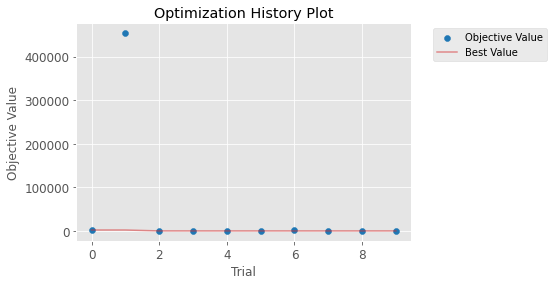

In [75]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

In [76]:
list(trial.params.items())

[('order', (2, 0, 1)), ('seasonal_order', (2, 2, 2, 12)), ('trend', None)]

In [77]:
order=list(trial.params.items())[0][1]
seasonal_order=list(trial.params.items())[1][1]
tr=list(trial.params.items())[2][1]

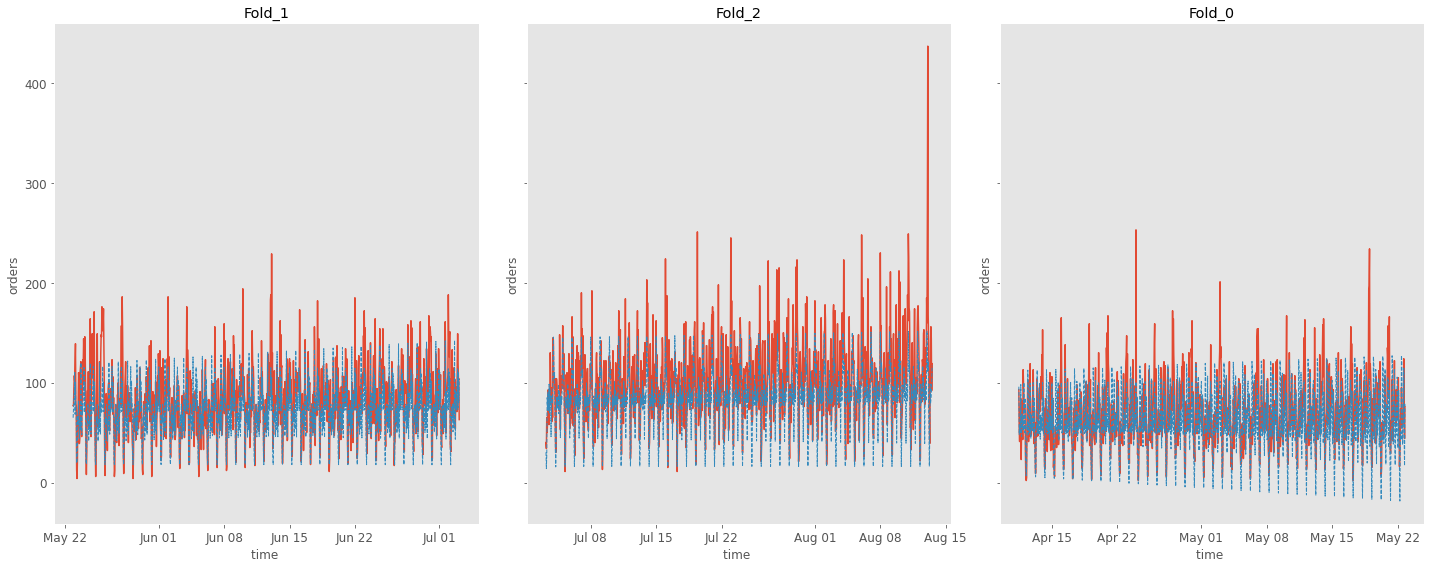

Результаты кросс-валидации SARIMAXa  [30.256264071059046, 27.92067710739734, 38.07488471116922]


In [78]:
rmsez=[]
t=train['num_orders'].copy()
fold=1

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True,figsize=(20, 8))

for fold, (train_index, test_index) in enumerate(tscv.split(t)):
    sarimax=sm.tsa.statespace.SARIMAX(t[train_index],order=order,seasonal_order=seasonal_order,trend=tr,initialization='approximate_diffuse')
    resultz=sarimax.fit()
    pred=resultz.predict(start=len(train_index),end=len(train_index)+len(test_index)-1,dynamic=True)
    loss = mean_squared_error(t[test_index], pred, squared=False)
    rmsez.append(loss)

    axs[fold-1].plot(t[test_index].index, t[test_index].values)
    axs[fold-1].set(xlabel='time ', ylabel='orders',title='Fold_{}'.format(fold))
    axs[fold-1].plot(t[test_index].index, pred,'--',linewidth=1)

    axs[fold-1].xaxis.set_major_formatter(formatter)
    axs[fold-1].grid()
    fold=fold+1
plt.show()
print("Результаты кросс-валидации SARIMAXa ",rmsez)

In [79]:
l=pd.Series(rmsez)
l=pd.concat([pd.Series('SARIMAX после оптимизации'), l,pd.Series(mean(rmsez))])
l=l.set_axis(eva.columns)
eva=eva.append(l, ignore_index=True)
eva

,Model,RMSE Fold1,RMSE Fold2,RMSE Fold3,Усреднённое RMSE
0,Линейная регрессия,21.418838,21.215641,26.628235,23.087571
1,Нейросеть,61.078812,93.206588,97.530743,83.938714
2,Prophet,27.813362,35.559377,35.336620,32.903120
3,SARIMAX без оптимизации,76.890972,89.943056,111.282757,92.705595
4,SARIMAX после оптимизации,30.256264,27.920677,38.074885,32.083942


**Вывод**

На этом мы закончим поиск модели.
1) Наиболее перспективным кандидатом по итогам кросс-валидации оказась модель на сонове бибилоитеки Prophet.

2) Неплохой результат показала модель SARIMAX, существенно улучшившись после оптимизации гипер-параметров, но всё равно недосатоточно хорошо. Вдобавок настораживает её прямолинейность по итогам кросс-валиадции.

3) Ключевым показателем для принятия решения стал RMSE на последнем фолде кросс-валидации, так как мы уже знаем, что хвост нашего датасета сильно отличается от его начала, даже при беглом визуальном осмотре.

4) Окончательным критерием выступит проверка на тестовой выборке и сравнение с результатами прямолинейного алгоритма - dummyregressor.

## Тестирование

In [93]:
m = Prophet(daily_seasonality=True, weekly_seasonality=True, seasonality_mode='multiplicative',changepoint_prior_scale=0.01)
m.fit(df_pr)
future = m.make_future_dataframe(periods=test_size,freq='H')
forecast = m.predict(future)
pred=forecast['yhat_upper'].tail(test_size)

loss = mean_squared_error(test['num_orders'], pred.astype(int), squared=False)
print('RMSE модели Prophet на тестовой выборке:',loss)

15:59:41 - cmdstanpy - INFO - Chain [1] start processing
15:59:41 - cmdstanpy - INFO - Chain [1] done processing


RMSE модели Prophet на тестовой выборке: 42.05837894901567


In [94]:
m1 = LinearRegression()
m1.fit(xl_train,yl_train)
forecast_l = m1.predict(xl_test)
loss = mean_squared_error(yl_test, forecast_l, squared=False)
print('RMSE линейной регрессии на тестовой выборке:',loss)

RMSE линейной регрессии на тестовой выборке: 35.5611779642631


In [95]:
dummy_regr = DummyRegressor(strategy="mean")
x_train=train.drop('num_orders', axis=1)
y_train=train['num_orders']
dummy_regr.fit(x_train, y_train)
x_test=test.drop('num_orders', axis=1)
pred=dummy_regr.predict(x_test)
loss = mean_squared_error(test['num_orders'], pred, squared=False)
print('RMSE DummyRegressor:',loss)

RMSE DummyRegressor: 84.74414402014742


**Ура! Наша модель даёт ошибку в два раза мешьне! И лучше целевого уровня в 48!**

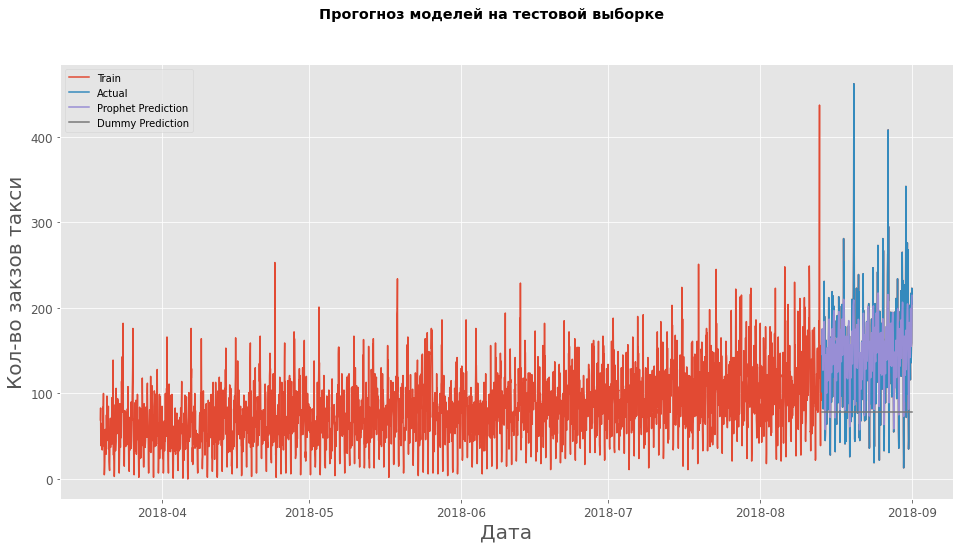

In [96]:
predictions = forecast['yhat_upper'].tail(test_size)  

# Визуализируем результаты
plt.rcParams["xtick.labelsize"] = 12
train_size = len(train)
test_size = len(test)
plt.figure(figsize=(16, 8))
plt.plot(df.index[-train_size:], df['num_orders'][-train_size:], label='Train')
plt.plot(df.index[-test_size:], df['num_orders'][-test_size:], label='Actual')
plt.plot(df.index[-test_size:], predictions, label='Prophet Prediction')
plt.plot(df.index[-test_size:], dummy_regr.predict(x_test), label='Dummy Prediction')
plt.suptitle('Прогогноз моделей на тестовой выборке',fontsize='x-large', fontweight='bold')
plt.xlabel("Дата", fontsize=20)
plt.ylabel("Кол-во закзов такси",fontsize=20)
plt.legend()
plt.show()

**Вывод:**

Модель не только показывает метрику лучше целевого уровня, и значительно лучше чем у DummyRegressor.
Визуализация подтверждает, что она хорошо уровила повыштельный тренд, который усилился в последний месяц, и даже пытается предугадывать аномальные всплески, хотя идёт их систематическая недооценка.

In [108]:
def fact_forecast(test_preds, y_test, dummy):
    
    '''Функция для визуализации качества регрессии "Факт-прогноз"'''
    plt.style.use('fivethirtyeight')
    y1 = test_preds
    y2 = y_test
    y3 =dummy
    x = y_test.index

    fig,ax = plt.subplots()
    fig.set_figwidth(20)
    fig.set_figheight(6)
    ax.set_xticks(x)
    fact = ax.plot(x, y2, linewidth = 2, label = 'Факт')
    forecast = ax.plot(x, y1, linewidth = 1, label = 'Prophet')
    dummy = ax.plot(x, y3, linewidth = 4, label = 'Dummy')
    linreg=ax.plot(x, forecast_l, linewidth = 1, label = 'Linear regression')
    ax.legend()
    ax.set_title('График "Факт-прогноз"', fontsize=20)
    ax.set_xlabel('Время')
    ax.set_ylabel('Количество заказов')
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(MultipleLocator(2)) 
    plt.show()

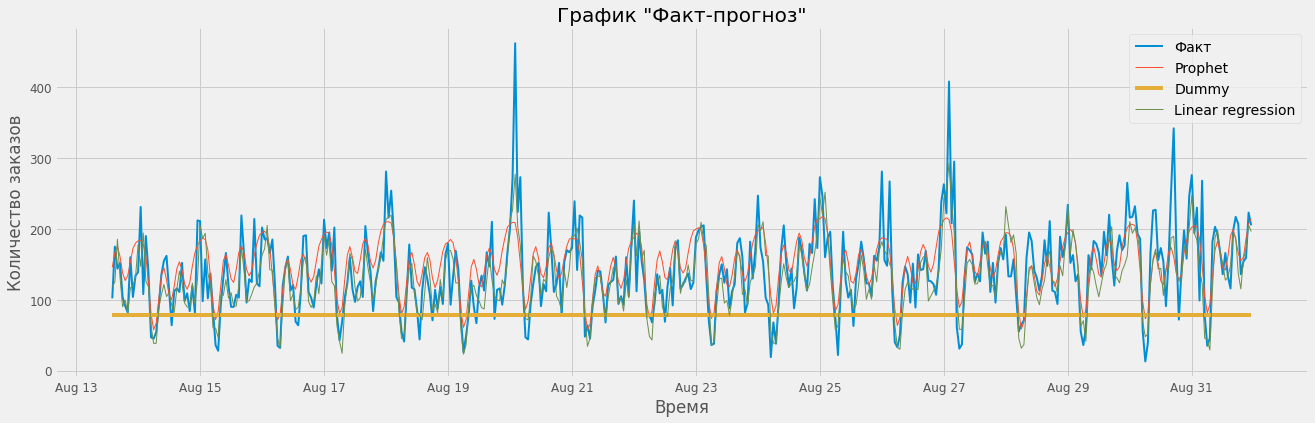

In [109]:
fact_forecast(predictions, df['num_orders'][-test_size:],dummy_regr.predict(x_test))

**Вывод**

- Этот график показывает как соотносятся прогнозные данные и фактический спрос на такси. 
- Модель немного ошибается в меньшую сторону, и не угадывает самые большие выбросы.
- Но это связано с тем, что данные последнего месяца уж сильно отличаются от более ранних периодов, на которых модель обучалась. 
- Хорошо бы иметь данные за несколько лет, чтобы учесть, например влияние всенародных праздников. 
- Ничто не моджет победить линейную регрессию.

**ИТОГОВЫЙ ВЫВОД:**
- Прогнозирование спроса на такси - сложная задача, перед которой пасуют даже продвинутые алгоритмы.
- Набор данных был достаточно высокого качества, но недостаточно большой, чтобы:
  - отразить ежегодные повторяющиеся события, типа всенародных праздников;
  - адекватно оценить изменение тренда, которое наметилось в последний месяц;
  - научиться предугадывать внезапные пики спроса, которые могут быть обусловлены изменением расписания в работе аэропортов, извержениями вулканов или иными причинами, не привязанными к календарю.
- Предобработка данных практически не понадобилась.
- В ходе выбора модели были рассмотрены линейная регрессия, нейросеть на базе слоёв LSTM, Prophet и SARIMAX. Последние две показали на кросс-валидации значения, лучше чем в целевых метриках.
- Модель на осонове линейной регрессии показала себя наиболее адекватно на тестовой выборке, без дополнительной оптимизации она позволила учесть и тренд и сезонные колебания, что дало метрики лучше целевых и лучше чем у аналогов, включая прямолинейный DummyRegressor.